In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from numba import jit
import mnist

In [2]:
# glorius globals
theta = 1e-1
dt = 1e-3
tau_syn = 1e-3
tau_stdp = 2e-3
u_reset = 0 
u_min = -theta/2 # stop runaway negative membrane potential 
gL = 1e-9
C = 1e-12
nh = 784
ad = 1e-12 # Uncorrelated ReSuMe term
dM = 1e-12 # sure?
b = np.zeros(nh)
eps = 0.5
denoising_steps = 5

@jit(nopython = True, fastmath=True)
def add_noise(x, n, N):
    p = 0.9*(n/N)**2 + 0.05
    permute = np.random.rand(*x.shape) < p
    a = np.random.rand(*x.shape)
    return x + permute*((a < 0.5)*(-x + theta) - (a > 0.5)*x)

@jit(nopython = True, fastmath=True)
def get_voltage(x):
    z = theta*(x > 0.5)
    return z

@jit(nopython = True, parallel=True, fastmath=True)
def get_current(x, min_p = 1e-5, max_p = 0.98):
    s = x/theta # from 0 to 1
    s = min_p*(s < min_p)+max_p*(s > max_p)
    return -np.log(-1 + 1. / (s))*1e-9

# @jit(nopython = True, parallel=True, fastmath=True)
def inference(u0:np.array, i0:np.array, w, nt:int = 10, ind:int = 0):

    u_pred = []
    I_pred = []

    u_pred.append(u0)
    I_pred.append(i0)

    for i in np.flip(np.arange(nt-1)): # notice reverse process
        u = np.zeros((denoising_steps, nh))
        I = np.zeros((denoising_steps, nh))

        prev_spikes = (u_pred[-1] >= theta)*1.0 
        u[0] = get_voltage(prev_spikes) # ensure no drift
        I[0] = get_current(u[0])

        u[0, i] = theta # clamp !
        u[0, nt + ind] = theta

        for j in range(denoising_steps-1):
            pre = u[j] >= theta 
            u[j] = u[j] + pre*(u_reset - u[j])  # no refractory time

            u[j, i] = theta
            u[j, nt + ind] = theta

            I[j+1] = I[j] + dt*(-I[j])/tau_syn + w@pre 
            u[j+1] = u[j] + dt*(-gL*u[j] + I[j+1])/C

            u[j+1, i] = theta 
            u[j+1, nt + ind] = theta

            u[j+1] = np.clip(u[j+1], u_min, theta) 

        u_pred.append(u[-1])
        I_pred.append(I[-1])
    return np.array(u_pred), np.array(I_pred)

# @jit(nopython = True, fastmath=True)
def run(nt:int, u_init:np.array, w:np.array, training:bool = True, ind:int = 0):

    target_voltage = np.zeros((nt, nh))
    target_voltage[0] = np.copy(u_init)

    pred_voltage = np.zeros((nt, nh))
    pred_current = np.zeros((nt, nh))

    M = np.zeros((nh, nh))

    track_w = np.zeros((nt-1, 784))
    track_w[0] = w[:784, 0]

    errors = np.zeros((nt-1, 3))

    for i in range(nt-1):
        
        target_spikes = np.copy(target_voltage[i] >= theta)
        target_voltage[i+1] = add_noise(target_voltage[i], i, nt)

        u = np.zeros((denoising_steps, nh))
        I = np.zeros((denoising_steps, nh))

        u[0] = target_voltage[i+1]
        I[0] = get_current(u[0])

        u[0, i] = theta # clamp !
        u[0, nt + ind] = theta

        for j in range(denoising_steps-1):
            pre = (u[j] >= theta)*1.0  
            u[j] = u[j] + pre*(u_reset - u[j])  # no refractory time

            u[j, i] = theta # clamp !
            u[j, nt + ind] = theta

            I[j+1] = I[j] + dt*(-I[j])/tau_syn + w@pre
            u[j+1] = u[j] + dt*(-gL*u[j] + I[j+1])/C

            u[j+1, i] = theta
            u[j+1, nt + ind] = theta
            u[j+1] = np.clip(u[j+1], u_min, theta)

            post = (u[j+1] >= theta)*1.0

        if training:
            M = M*np.exp(-dt/tau_stdp) + np.outer(np.ones(nh), pre)*dM

            w = w - eps*np.outer(post, np.ones(nh))*(ad + M)
            w = w + eps*np.outer(target_spikes, np.ones(nh))*(ad + M)

        track_w[i] = w[:784, 0]

        error = target_spikes*1.0 - post*1.0
        errors[i,0] = np.sum(error == 0)
        errors[i,1] = np.sum(error == 1)
        errors[i,2] = np.sum(error == -1)

        pred_voltage[i] = u[-1]
        pred_current[i] = I[-1]

    return pred_voltage, pred_current, target_voltage, track_w, errors, w

In [3]:
def transform_mnist(x, labels):
    x = x.reshape((x.shape[0], 784))
    x /= 255.
    return x 

[MNIST] Caching data at MNIST
[MNIST] Found http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz in cache.
[MNIST] Found http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz in cache.
[MNIST] Found http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz in cache.
[MNIST] Found http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz in cache.


(-0.5, 27.5, 27.5, -0.5)

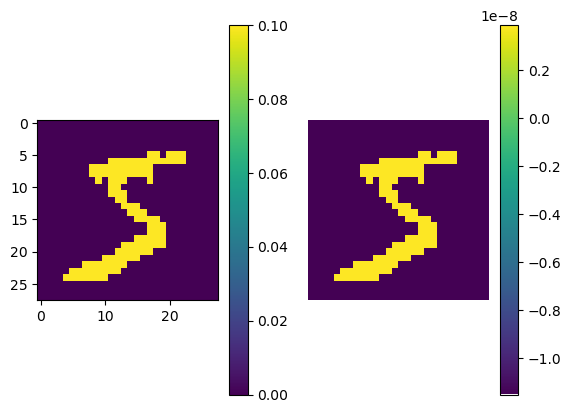

In [4]:
x_train, y_train, x_test, y_test = mnist.mnist('MNIST')
x_train = transform_mnist(x_train, y_train)
x_test = transform_mnist(x_test, y_test)

nh = 784
w = np.random.normal(0, 0.3*1e-9, (nh, nh))

u_train, u_test = get_voltage(x_train), get_voltage(x_train)
I_train, I_test = get_current(u_train), get_current(u_test)
u_train.shape
fig, ax = plt.subplots(1, 2)
im1 = ax[0].imshow(u_train[0].reshape((28, 28)))
im2 = ax[1].imshow(I_train[0].reshape((28,28)))
fig.colorbar(im1, ax =ax[0])
fig.colorbar(im2, ax = ax[1])
plt.axis("off")

In [5]:
def plot_experiment(u, spikes, target, titles = None, figsize = (30, 5)):
    fig,ax = plt.subplots(3, len(u), figsize = figsize)

    for i in range(0, len(u)):
        for j, val in enumerate([u, spikes, target]):
            im = ax[j,i].imshow(val[i].reshape(28,28))
            fig.colorbar(im, ax = ax[j,i], fraction = 0.045)
    plt.tight_layout()

    if titles is not None:
        [axi[0].set_ylabel(title) for axi, title in zip(ax, titles)]
    return fig, ax

# Baseline

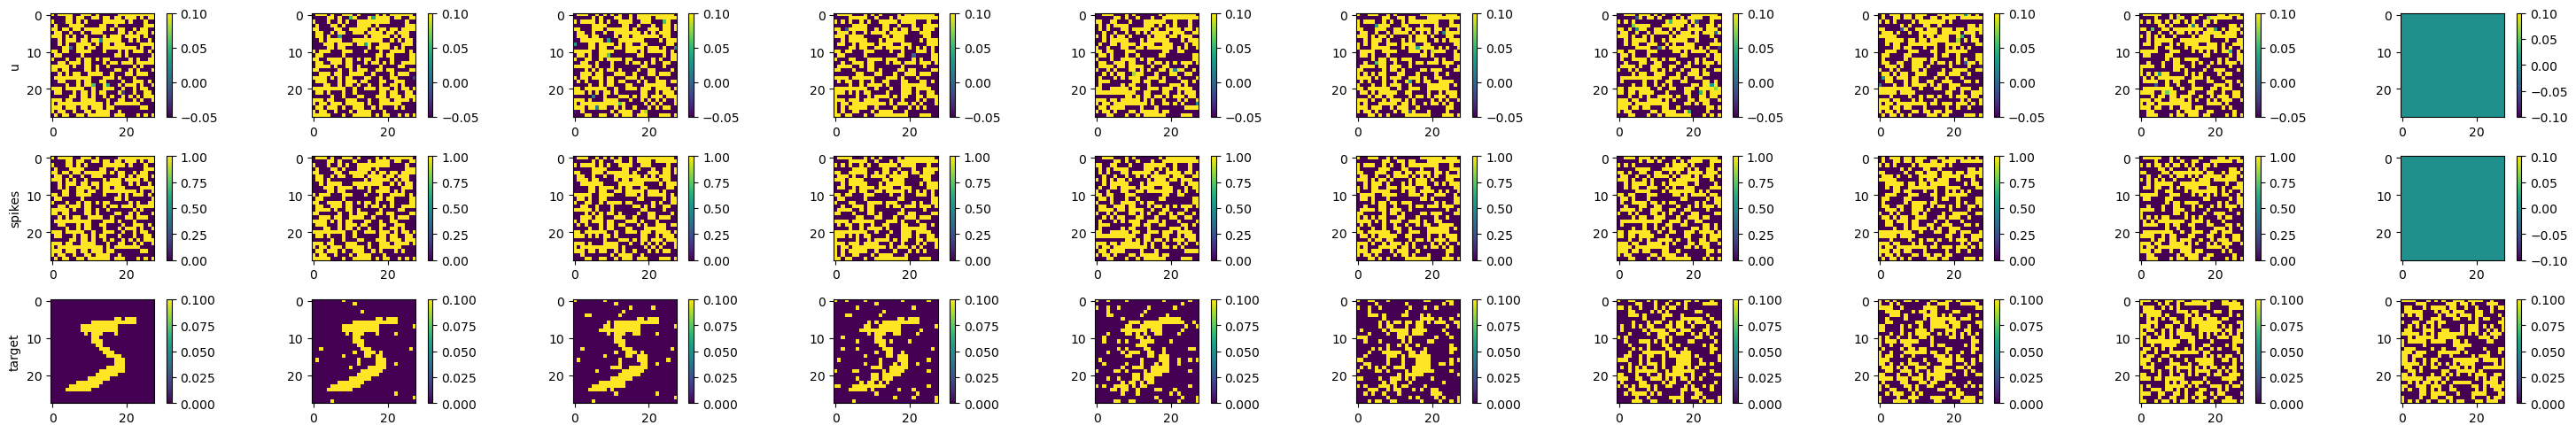

In [6]:
run_steps = 10
show_step = 1

u, I, target, a, error, w = run(run_steps, u_train[0], w, training = False)

fig,ax = plot_experiment(u, u >= theta, target, ["u", "spikes", "target"]) # membrane potential, spikes, and targets (noisy neurons)

# Baseline inference

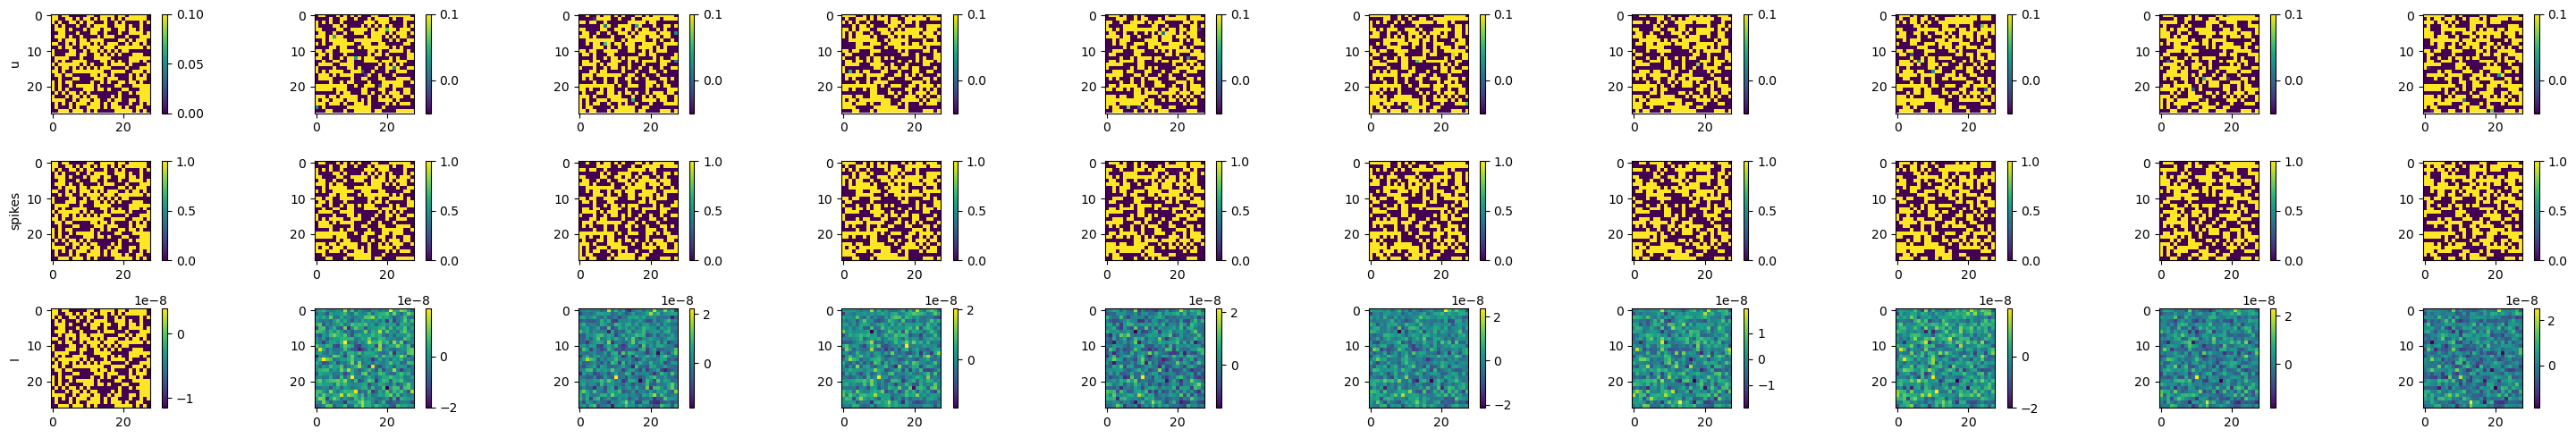

In [7]:
noise = np.random.choice([0, 1], size = 784)
u_noise = get_voltage(noise)
I_noise = get_current(u_noise)

u, I = inference(u_noise, I_noise,w, run_steps)
spikes = u >= theta
fig,ax = plot_experiment(u, spikes, I, ["u", "spikes", "I"])

In [8]:
train_steps = 10000 #len(x_train)

if train := True:
    errors = []
    ws = []
    for i in tqdm(range(train_steps)):
        u, I, target, a, error, w = run(run_steps, u_train[i], w, ind = y_train[i])
        if (i % 100 == 0):
            ws.append(a)
            errors.append(error)

    np.save("diffusion_w", w)
# w = np.load("diffusion_w.npy")

100%|██████████| 10000/10000 [10:35<00:00, 15.75it/s]


# Test inference

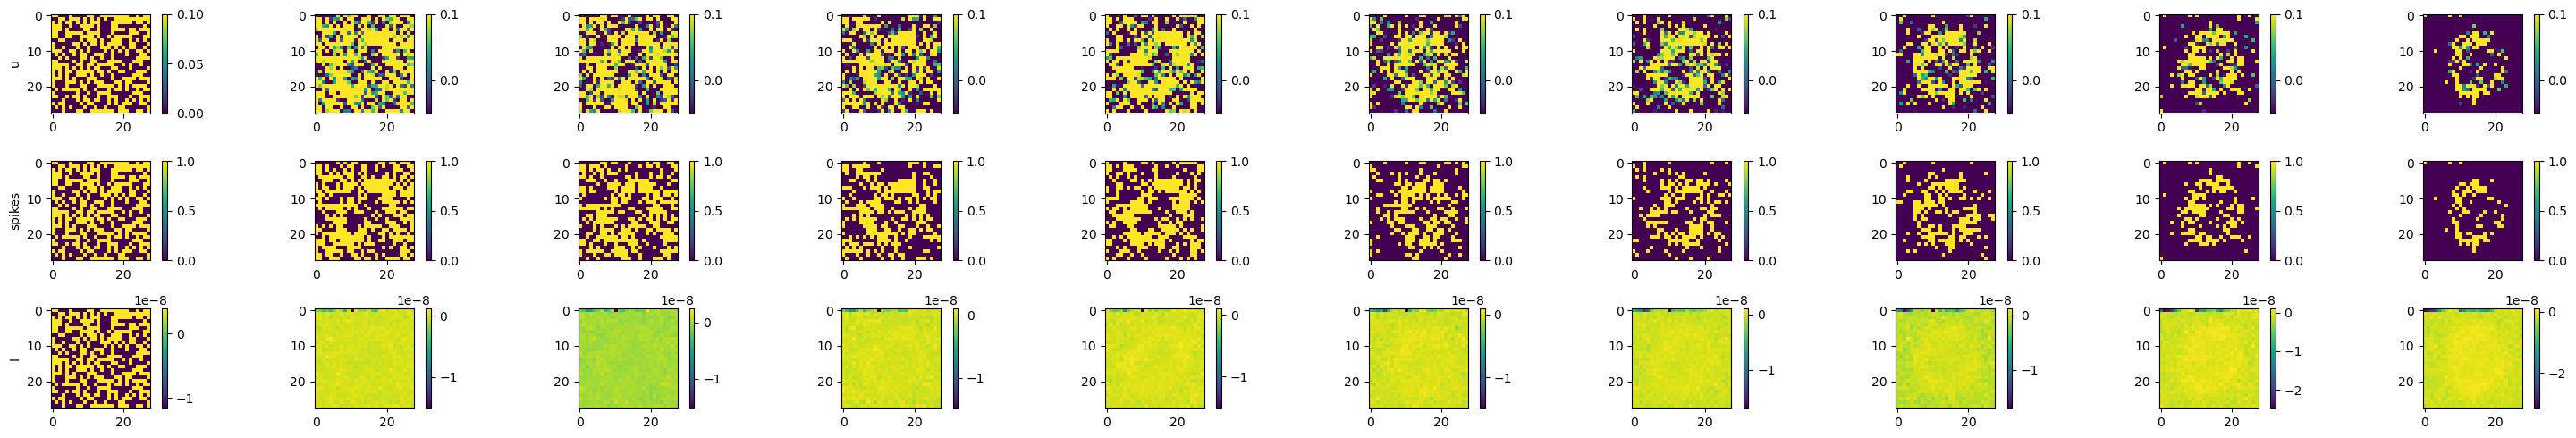

In [29]:
noise = np.random.choice([0, 1], size = 784)

u_noise = get_voltage(noise)
I_noise = get_current(u_noise)

run_steps = 10
ind = 0 # class label

u, I = inference(u_noise, I_noise, w, run_steps, ind) # left is initial time step
fig,ax = plot_experiment(u, u >= theta, I, ["u", "spikes", "I"]) # need to run for multiple steps!